# In this notebook, I use the update rules according to the last notebook (based on the Newton-Raphson method) on the MNIST dataset.

-------------------------------------------------------------------------------------------------------------------

# This notebook also generates the comparison summary against the prevailing first order (not using hessian) optimization techniques.

-------------------------------------------------------------------------------------------------------------------

## Technology used: TensorFlow

start with the usual cells. I don't remember how I attained this habit. Anyway, let's get started:

In [1]:
# import all the required packages: 
# packages used for processing: 
from __future__ import print_function # making backward compatible

import matplotlib.pyplot as plt # for visualization
import numpy as np

# THE TensorFlow framework
import tensorflow as tf
# use the tensorflow's archived version of the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
# import tensorflow debugger:
from tensorflow.python import debug as tf_debug

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
Error_analysis
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
# set a seed value for the script
seed_value = 3

In [5]:
np.random.seed(seed_value) # set this seed for a device independant consistent behaviour

In [6]:
''' Set the constants for the script '''

# various paths of the files
base_data_path = "../../Data" # the data path

base_model_path = "../../Models/IDEA_2"

# constant values for the script
num_digits = 10 # This is defined. There are 10 labels for 10 digits
img_dim = 28 # images are 28 x 28 sized

In [7]:
# Hyper parameters for tweaking.
# =================================================================================================================
training_batch_size = 64 # 64 images in each batch
no_of_epochs = 12


# network architecture related parameters:
''' Note that the number of layers will be fixed. you can tweak the number of hidden neurons in these layers: '''
num_hidden_lay_1 = 512
num_hidden_lay_2 = 512
num_hidden_lay_3 = num_digits

# learning rate required for other optimizers:
learning_rate = 3e-4 # lolz! the karpathy constant
# =================================================================================================================

In [8]:
mnist = input_data.read_data_sets(os.path.join(base_data_path, "MNIST_data"), seed=seed_value, one_hot=True)

Extracting ../../Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
train_X = mnist.train.images; train_Y = mnist.train.labels
dev_X = mnist.validation.images; dev_Y = mnist.validation.labels
test_X = mnist.test.images; test_Y = mnist.test.labels

In [10]:
# print all the shapes:
print("Training Data shapes: ", train_X.shape, train_Y.shape)
print("Development Data shapes: ", dev_X.shape, dev_Y.shape)
print("Test Data shapes: ", test_X.shape, test_Y.shape)

Training Data shapes:  (55000, 784) (55000, 10)
Development Data shapes:  (5000, 784) (5000, 10)
Test Data shapes:  (10000, 784) (10000, 10)


In [11]:
# define the total_train_examples, total_dev_examples and the total_test_examples using the above arrays
total_train_examples = train_X.shape[0]
total_dev_examples = dev_X.shape[0]
total_test_examples = test_X.shape[0]
input_dimension = train_X.shape[1]

In [12]:
# just double checking if all the values are correct:
print("Training_data_size =", total_train_examples)
print("Development_data_size =", total_dev_examples)
print("Test_data_size =", total_test_examples)
print("Input data dimensions =", input_dimension)

Training_data_size = 55000
Development_data_size = 5000
Test_data_size = 10000
Input data dimensions = 784


the following is a randomized cell for visualizing the input data. This is just to verify the sanity of the data

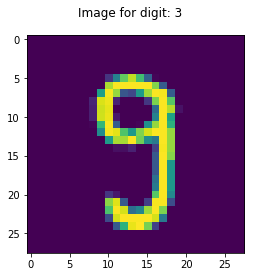

In [13]:
''' Randomized cell: Behaviour changes upon running multiple times '''

random_index = np.random.randint(total_train_examples)

# bring the random image from the training data
random_image = train_X[random_index].reshape((img_dim, img_dim))
label_for_random_image = np.argmax(train_Y[random_index])

# display this random image:
plt.figure().suptitle("Image for digit: " + str(label_for_random_image))
plt.imshow(random_image);

### seems like we have randomly landed on a mislabelled example! That's the magic of the random_seed_value = 3

don't worry! There is no jumbling in the labels. Run the above cell more times and you will see that it was just that one example that is mis labelled in the original dataset itself.

# Experimentation: 

Create the neural network graph for classifying the mnist dataset. This is going to be a very simple graph. With just three fully connected layers and there is no regularization (L2 or dropouts).

point to restart the graph building process:


In [14]:
tf.reset_default_graph()

In [15]:
layer1 = tf.layers.Dense(
            units = num_hidden_lay_1,
            activation = tf.nn.relu,
            use_bias = True,
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            name = "fully_connected"
         )

layer2 = tf.layers.Dense(
            units = num_hidden_lay_2,
            activation = tf.nn.relu,
            use_bias = True,
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            name = "fully_connected"
         )

layer3 = tf.layers.Dense(
            units = num_hidden_lay_3,
            activation = None, # note that here we apply the softmax nonlinearity for obtaining the probabilities 
            use_bias = True,
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            name = "fully_connected"
         )

define the input placeholders for the computations

In [16]:
with tf.name_scope("Input_Placeholders"):
    tf_input_images = tf.placeholder(tf.float32, shape=(None, input_dimension), name="input_images")
    tf_input_labels = tf.placeholder(tf.float32, shape=(None, num_digits), name="input_labels")

define the neural_network computations layer by layer:

In [17]:
with tf.variable_scope("Layer_1"):
    lay_1_out = layer1(tf_input_images)

In [18]:
with tf.variable_scope("Layer_2"):
    lay_2_out = layer2(lay_1_out)

In [19]:
with tf.variable_scope("Layer_3"):
    lay_3_out = layer3(lay_2_out)

check the dimensionality of the lay_3_output

In [20]:
lay_3_out

<tf.Tensor 'Layer_3/fully_connected/BiasAdd:0' shape=(?, 10) dtype=float32>

The shape is as expected:

In [21]:
# extract all the weights and biases from the layers for summary generation
lay_1_kernel, lay_1_biases = layer1.weights
lay_2_kernel, lay_2_biases = layer2.weights
lay_3_kernel, lay_3_biases = layer3.weights

# attach summary op to all the trainable weights and biases of the three layers:
lay_1_k_sum = tf.summary.histogram("l1_k", lay_1_kernel); lay_1_b_sum = tf.summary.histogram("l1_b", lay_1_biases)
lay_2_k_sum = tf.summary.histogram("l2_k", lay_2_kernel); lay_2_b_sum = tf.summary.histogram("l2_b", lay_2_biases)
lay_3_k_sum = tf.summary.histogram("l3_k", lay_3_kernel); lay_3_b_sum = tf.summary.histogram("l3_b", lay_3_biases)

In [22]:
# define the predictions:
with tf.name_scope("Predictions"):
    predictions = tf.nn.softmax(lay_3_out)

In [23]:
# define the loss for the model
with tf.name_scope("Loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_input_labels, logits=lay_3_out))
    
    # add a scalar summary for the loss:
    loss_summary = tf.summary.scalar("Loss", loss)

In [24]:
# define the errands for this model:
with tf.name_scope("Errands"):
    all_summaries = tf.summary.merge_all()

## session and runners:

In [25]:
# define a pseudo session to generate the visualizer and for printing all the trainable variables in the model
with tf.Session() as sess:
    # create the tensorboard writer:
    tensorboard_writer = tf.summary.FileWriter(os.path.join(base_model_path, "Visualizer"), graph=sess.graph, 
                                              filename_suffix = ".bot")
    
    # init the session:
    sess.run(tf.global_variables_initializer())
    
    # print all the trainable variables in the graph: 
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)
    
    for var, val in zip(tvars, tvars_vals):
        print(var.name)

Layer_1/fully_connected/kernel:0
Layer_1/fully_connected/bias:0
Layer_2/fully_connected/kernel:0
Layer_2/fully_connected/bias:0
Layer_3/fully_connected/kernel:0
Layer_3/fully_connected/bias:0


Run tensorboard with the Models/IDEA_2 as the logdir to view all these visualizations:

In [54]:
# define the function for training the above model along with the optimizer as an argument to it:
def train(X, Y, batch_size, no_of_epochs, optimizing_step, model_path, model_name, debug=False):
    '''
        Function to train the above generated graph using the optimizing step privided
        
        Arguments:
        X, Y = The data to train on.
        batch_size = size of each minibatch
        no_of_epochs = no of epochs to train for
        optimizing_step = the tensorflow op that optimizes the weights
        model_path = The path where the trained model is to be saved
        model_name = The name of the model for saving
        debug = boolean controlling if it needs to be a debugging session
    '''
    
    # This is a temporary code and not the full blown:
    sess = tf.InteractiveSession()
        
    if(debug):
        sess = tf_debug.LocalCLIDebugWrapperSession(sess)

    # create a tensorboard writer
    tensorboard_writer = tf.summary.FileWriter(logdir=model_path, 
                                               graph=sess.graph, filename_suffix=".bot")

    # create a saver
    saver = tf.train.Saver(max_to_keep=3)

    # restore the session if the checkpoint exists:
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        saver.restore(sess, tf.train.latest_checkpoint(model_path))

    else: # initialize all the variables:
        sess.run(tf.global_variables_initializer())

    global_step = 0
    print("Starting the training process . . .")
    for epoch in range(no_of_epochs):

        # run through the batches of the data:
        for batch in range(int(np.ceil(float(total_train_examples) / batch_size))):
            start = batch * batch_size; end = start + batch_size

            # extract the relevant data:
            batch_data_X = X[start: end]
            batch_data_Y = Y[start: end]

            _, cost, sums = sess.run([optimizing_step, loss, all_summaries], 
                                                    feed_dict={tf_input_images: batch_data_X, 
                                                              tf_input_labels: batch_data_Y})

            # save the summaries
            if(batch % 50 == 0):
                tensorboard_writer.add_summary(sums, global_step)

            # increment the global step 
            global_step += 1

        print("epoch = ", epoch, "cost = ", cost)

        # save the model after every epoch
        saver.save(sess, os.path.join(model_path, model_name), global_step=(epoch + 1))

    # Once, the training is complete:
    print("Training complete . . .")
    
    # close the session -> 
    sess.close()

# Train using the Adam optimizer:

In [27]:
# define the Adam trainer for the model defined
with tf.name_scope("Adam_Trainer"):
    train_step_adam = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [28]:
model_name = "Adam_Model"
model_save_path = os.path.join(base_model_path, model_name)

In [29]:
train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_adam, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  0.0238923
epoch =  1 cost =  0.0121582
epoch =  2 cost =  0.00975432
epoch =  3 cost =  0.00316183
epoch =  4 cost =  0.00104458
epoch =  5 cost =  0.000663358
epoch =  6 cost =  0.000234343
epoch =  7 cost =  0.000399052
epoch =  8 cost =  0.000117259
epoch =  9 cost =  0.000197179
epoch =  10 cost =  7.91406e-05
epoch =  11 cost =  3.6454e-05
Training complete . . .


# Train using the Adadelta Optimizer

In [31]:
# define the Adadelta trainer for the model defined
with tf.name_scope("Adadelta_Trainer"):
    train_step_adadelta = tf.train.AdadeltaOptimizer().minimize(loss) # using the default learning rate
    
model_name = "Adadelta_Model"
model_save_path = os.path.join(base_model_path, model_name)

train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_adadelta, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  2.28419
epoch =  1 cost =  2.21074
epoch =  2 cost =  2.14024
epoch =  3 cost =  2.07137
epoch =  4 cost =  2.00229
epoch =  5 cost =  1.93292
epoch =  6 cost =  1.86265
epoch =  7 cost =  1.79168
epoch =  8 cost =  1.72065
epoch =  9 cost =  1.64979
epoch =  10 cost =  1.5789
epoch =  11 cost =  1.50826
Training complete . . .


# Train using the Adagrad Optimizer

In [33]:
# define the Adagrad trainer for the model defined
with tf.name_scope("Adagrad_Trainer"):
    train_step_adagrad = tf.train.AdagradOptimizer(learning_rate).minimize(loss) 
    
model_name = "Adagrad_Model"
model_save_path = os.path.join(base_model_path, model_name)

train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_adagrad, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  1.8792
epoch =  1 cost =  1.39008
epoch =  2 cost =  1.02289
epoch =  3 cost =  0.784186
epoch =  4 cost =  0.628431
epoch =  5 cost =  0.521987
epoch =  6 cost =  0.445172
epoch =  7 cost =  0.387286
epoch =  8 cost =  0.342278
epoch =  9 cost =  0.306636
epoch =  10 cost =  0.277921
epoch =  11 cost =  0.254449
Training complete . . .


# Train using the GradientDescentOptimizer

In [34]:
# define the GradientDescent trainer for the model defined
with tf.name_scope("GradientDescent_Trainer"):
    train_step_gradDesc = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
model_name = "GradientDescent_Model"
model_save_path = os.path.join(base_model_path, model_name)

train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_gradDesc, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  2.09428
epoch =  1 cost =  1.94123
epoch =  2 cost =  1.7722
epoch =  3 cost =  1.59662
epoch =  4 cost =  1.42495
epoch =  5 cost =  1.26431
epoch =  6 cost =  1.11987
epoch =  7 cost =  0.993336
epoch =  8 cost =  0.885756
epoch =  9 cost =  0.795108
epoch =  10 cost =  0.718521
epoch =  11 cost =  0.653813
Training complete . . .


# Train using MomentumOptimizer

In [35]:
# define the Momentum trainer for the model defined
with tf.name_scope("Momentum_Trainer"):
    train_step_momentum = tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(loss)
    
model_name = "MomentumOptimizer_Model"
model_save_path = os.path.join(base_model_path, model_name)

train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_momentum, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  0.850098
epoch =  1 cost =  0.387051
epoch =  2 cost =  0.249473
epoch =  3 cost =  0.186767
epoch =  4 cost =  0.152059
epoch =  5 cost =  0.13041
epoch =  6 cost =  0.115708
epoch =  7 cost =  0.104882
epoch =  8 cost =  0.0965706
epoch =  9 cost =  0.0900359
epoch =  10 cost =  0.0847443
epoch =  11 cost =  0.0802271
Training complete . . .


# Train using RMSPropOptimizer

In [36]:
# define the Momentum trainer for the model defined
with tf.name_scope("RMSProp_Trainer"):
    train_step_rmsprop = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
    
model_name = "RMSpropOptimizer_Model"
model_save_path = os.path.join(base_model_path, model_name)

train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_rmsprop, model_save_path, model_name)

Starting the training process . . .
epoch =  0 cost =  0.0177101
epoch =  1 cost =  0.00564126
epoch =  2 cost =  0.00187299
epoch =  3 cost =  0.000821726
epoch =  4 cost =  0.00041412
epoch =  5 cost =  0.000233829
epoch =  6 cost =  0.000173776
epoch =  7 cost =  9.69946e-05
epoch =  8 cost =  3.88677e-05
epoch =  9 cost =  8.10112e-06
epoch =  10 cost =  1.12947e-05
epoch =  11 cost =  2.38279e-05
Training complete . . .


# Train using the RANIK_Optimizer

In [52]:
# The op used for defining the optimizer:
with tf.name_scope("ranik"):
    # obtain the gradients of the cost wrt all the three layers' parameters
    with tf.name_scope("gradients"):
        gra_lay_1_kernel, gra_lay_1_biases = tf.gradients(loss, [lay_1_kernel, lay_1_biases])
        gra_lay_2_kernel, gra_lay_2_biases = tf.gradients(loss, [lay_2_kernel, lay_2_biases])
        gra_lay_3_kernel, gra_lay_3_biases = tf.gradients(loss, [lay_3_kernel, lay_3_biases])
    
    # define the ops for updating the three layers kernels and biases
    with tf.name_scope("update"):
        op1=tf.assign(lay_1_kernel, lay_1_kernel-((loss * gra_lay_1_kernel) / (loss + tf.square(gra_lay_1_kernel))))
        op2=tf.assign(lay_1_biases, lay_1_biases-((loss * gra_lay_1_biases) / (loss + tf.square(gra_lay_1_biases))))
        op3=tf.assign(lay_2_kernel, lay_2_kernel-((loss * gra_lay_2_kernel) / (loss + tf.square(gra_lay_2_kernel))))
        op4=tf.assign(lay_2_biases, lay_2_biases-((loss * gra_lay_2_biases) / (loss + tf.square(gra_lay_2_biases))))
        op5=tf.assign(lay_3_kernel, lay_3_kernel-((loss * gra_lay_3_kernel) / (loss + tf.square(gra_lay_3_kernel))))
        op6=tf.assign(lay_3_biases, lay_3_biases-((loss * gra_lay_3_biases) / (loss + tf.square(gra_lay_3_biases))))
        
        # group all the 6 ops into one
        update_step = tf.group(op1, op2, op3, op4, op5, op6, name="combined_update")

In [55]:
# define the Ranik trainer for the model defined
with tf.name_scope("Ranik_Trainer"):
    train_step_ranik = update_step
    
model_name = "RanikOptimizer_Model"
model_save_path = os.path.join(base_model_path, model_name)

# train(train_X, train_Y, training_batch_size, no_of_epochs, train_step_ranik, model_save_path, model_name, debug=True)


tfdbg: caught SIGINT; calling sys.exit(1).


SystemExit: 1

/home/animesh/Programming/platforms/anaconda3/envs/snakes/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
# restore model and obtain the training and test accuracy:
model_name = "RanikOptimizer_Model"
model_save_path = os.path.join(base_model_path, model_name)

print(model_save_path)

../../Models/IDEA_2/RanikOptimizer_Model


In [37]:
saver = tf.train.Saver(max_to_keep=3)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(model_save_path))
    
    # calculate predictions on the training dataset
    preds_train = sess.run(predictions, feed_dict={tf_input_images: train_X})
    
    # calculate the predictions on the dev dataset
    preds_dev = sess.run(predictions, feed_dict={tf_input_images: dev_X})
    
    # calculate the predictions on the test dataset
    preds_test = sess.run(predictions, feed_dict={tf_input_images: test_X})

INFO:tensorflow:Restoring parameters from ../../Models/IDEA_2/RanikOptimizer_Model/RanikOptimizer_Model-12


In [40]:
# calculate the dev accuracy:
train_accuracy = (np.sum((np.argmax(preds_train, axis=-1) == np.argmax(train_Y, axis=-1)).astype(np.float32)) / len(preds_train)) * 100
print("Train_set_accuracy =", train_accuracy)

# calculate the dev accuracy:
dev_accuracy = (np.sum((np.argmax(preds_dev, axis=-1) == np.argmax(dev_Y, axis=-1)).astype(np.float32)) / len(preds_dev)) * 100
print("Dev_set_accuracy =", dev_accuracy)

# calculate the dev accuracy:
test_accuracy = (np.sum((np.argmax(preds_test, axis=-1) == np.argmax(test_Y, axis=-1)).astype(np.float32)) / len(preds_test)) * 100
print("Test_set_accuracy =", test_accuracy)

Train_set_accuracy = 97.9963636364
Dev_set_accuracy = 96.42
Test_set_accuracy = 96.21


In [41]:
# restore model and obtain the training and test accuracy:
model_name = "Adam_Model"
model_save_path = os.path.join(base_model_path, model_name)

print(model_save_path)

saver = tf.train.Saver(max_to_keep=3)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(model_save_path))
    
    # calculate predictions on the training dataset
    preds_train = sess.run(predictions, feed_dict={tf_input_images: train_X})
    
    # calculate the predictions on the dev dataset
    preds_dev = sess.run(predictions, feed_dict={tf_input_images: dev_X})
    
    # calculate the predictions on the test dataset
    preds_test = sess.run(predictions, feed_dict={tf_input_images: test_X})
    

    
# calculate the dev accuracy:
train_accuracy = (np.sum((np.argmax(preds_train, axis=-1) == np.argmax(train_Y, axis=-1)).astype(np.float32)) / len(preds_train)) * 100
print("Train_set_accuracy =", train_accuracy)

# calculate the dev accuracy:
dev_accuracy = (np.sum((np.argmax(preds_dev, axis=-1) == np.argmax(dev_Y, axis=-1)).astype(np.float32)) / len(preds_dev)) * 100
print("Dev_set_accuracy =", dev_accuracy)

# calculate the dev accuracy:
test_accuracy = (np.sum((np.argmax(preds_test, axis=-1) == np.argmax(test_Y, axis=-1)).astype(np.float32)) / len(preds_test)) * 100
print("Test_set_accuracy =", test_accuracy)

../../Models/IDEA_2/Adam_Model
INFO:tensorflow:Restoring parameters from ../../Models/IDEA_2/Adam_Model/Adam_Model-12
Train_set_accuracy = 99.6690909091
Dev_set_accuracy = 98.2
Test_set_accuracy = 97.82
